# Fit the flight acquisition probability model including PEA 2022 data

Fit values here were computed 2017-Aug-9

This version introduces a dependence on the search box size.  Search box sizes of 160 or 180 arcsec
(required for at least 3 star slots) were used in normal operations starting in the MAR2017 products.  This followed
two PMSTA anomalies.

In addition this version uses the 2017 dark current model from chandra_aca version 3.15.  This requires computing the warm pixel fraction values instead of using the values provided in the acqusition database.

In [1]:
from __future__ import division

import sys
sys.path.insert(0, '/home/aldcroft/git/chandra_aca')
import re
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
from astropy.time import Time
import tables
from scipy import stats
import tables3_api
from chandra_aca.dark_model import get_warm_fracs
from chandra_aca import star_probs
import pea_utils
from Chandra.Time import DateTime

%matplotlib inline

### Final 2017 fit values

In [2]:
SOTA2022_FIT_NO_1P5 = [7.78471,  # scl0
                       -3.70337,  # scl1
                       -2.84246,  # scl2
                       -3.19593,  # off0
                       2.86478,  # off1
                       1.28957,  # off2
                       0.03537,  # p_bright_fail
                       ]

In [3]:
SOTA2017_FIT_NO_1P5 = [4.38145,  # scl0
                       6.22480,  # scl1
                       2.20862,  # scl2
                       -2.24494,  # off0
                       0.32180,  # off1
                       0.08306,  # off2
                       0.00384,  # p_bright_fail
                       ]

In [4]:
SOTA2017_FIT_ONLY_1P5 = [4.73283,  # scl0
                         7.63540,  # scl1
                         4.56612,  # scl2
                         -1.49046,  # off0
                         0.53391,  # off1
                         -0.37074,  # off2
                         0.00199,  # p_bright_fail
                         ]

### Final 2015 fit values

In [5]:
SOTA2015_FIT_ALL = [3.9438714542029976, 5.4601129927961134, 1.6582423213669775, 
                    -2.0646518576907495, 0.36414269305801689, -0.0075143036207362852, 
                    0.003740065500207244]


In [6]:
SOTA2015_FIT_NO_1P5 = [4.092016310373646, 6.5415918325159641, 1.8191919043258409, 
                       -2.2301709573082413, 0.30337711472920426, 0.10116735012955963, 
                       0.0043395964215468185]

In [7]:
SOTA2015_FIT_ONLY_1P5 = [4.786710417762472, 4.839392687262392, 1.8646719319052267, 
                         -1.4926740399312248, 0.76412972998935347, -0.20229644263097146, 
                         0.0016270748026844457]

In [8]:
import chandra_aca
chandra_aca.__version__

'3.17'

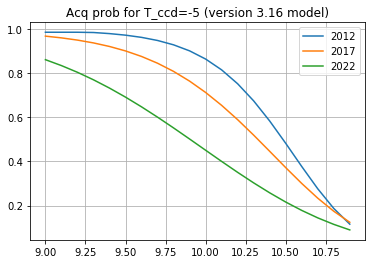

In [9]:
mag = np.arange(9, 11, 0.1)
prob1 = star_probs.acq_success_prob(date='2012:001', t_ccd=-5, mag=mag)
prob2 = star_probs.acq_success_prob(date='2017:001', t_ccd=-5, mag=mag)
prob3 = star_probs.acq_success_prob(date='2022:001', t_ccd=-5, mag=mag)
plt.plot(mag, prob1, label='2012')
plt.plot(mag, prob2, label='2017')
plt.plot(mag, prob3, label='2022')
plt.legend()
plt.title('Acq prob for T_ccd=-5 (version 3.16 model)')
plt.grid();

## Fit code

In [10]:
with tables.open_file('/proj/sot/ska/data/acq_stats/acq_stats.h5', 'r') as h5:
    cols = h5.root.data.cols
    names = {'tstart': 'guide_tstart',
             'obsid': 'obsid',
             'obc_id': 'acqid',
             'halfwidth': 'halfw',
             'warm_pix': 'n100_warm_frac',
             'mag': 'mag_aca',
             'known_bad': 'known_bad',
             'color': 'color1',
            'img_func': 'img_func', 
            'ion_rad': 'ion_rad',
            'sat_pix': 'sat_pix',
            'ccd_temp': 'ccd_temp'}
    acqs = Table([getattr(cols, h5_name)[:] for h5_name in names.values()],
                 names=list(names.keys()))

    year_q0 = 1999.0 + 31. / 365.25  # Jan 31 approximately

In [11]:
acqs[:2]

tstart,obsid,obc_id,halfwidth,warm_pix,mag,known_bad,color,img_func,ion_rad,sat_pix,ccd_temp
float64,int64,bool,int64,float64,float64,bool,float64,bytes7,bool,bool,float64
126799024.047,61357,True,120,0.0475056717743,7.159948349,False,1.5,star,False,False,-10.3720703125
126799024.047,61357,True,120,0.0475056717743,8.84398651123,False,1.48495054245,star,False,False,-10.3720703125


## Process PEA test set data for 2022 synthetic dark cal at T_ccd = -5, -7, -9, -11, -13 C

In [12]:
# Read in data and flatten into a one-star-acq per one-row format
filename = 'PeaTestSetTempAndEpochAcqTesting/pea_analysis_results_2017_219_future_perf.csv'
dat8 = pea_utils.read_twiki_csv(filename)
dat = pea_utils.flatten_pea_test_data(dat8)

In [13]:
# Pick out the columns we need and rename / define to match the acq stats database cols
datc = Table(dat['ref_obsid', 'search_success', 'slot_box_hw', 'star_mag', 'ccd_temp'],
             names=('obsid', 'search_success', 'halfwidth', 'mag', 'ccd_temp'))
datc['obc_id'] = datc['search_success'].astype(bool)
datc['tstart'] = DateTime('2022:001').secs
datc['warm_pix'] = -1  # updated later
datc['ion_rad'] = False
datc['sat_pix'] = False
# Define 'img_func' to be something other than 'star' because the ms_disabled=True
# processing does effectively obc_id |= img_func == 'star'
datc['img_func'] = 'pea star'
datc['color'] = 1.0
datc['known_bad'] = False

In [14]:
# Adjust probability (in probit space) for box size.  See:
# https://github.com/sot/skanb/blob/master/pea-test-set/fit_box_size_acq_prob.ipynb
b1 = 0.96
b2 = -0.30
box0 = (datc['halfwidth'] - 120) / 120  # normalized version of box, equal to 0.0 at nominal default
datc['box_delta'] = b1 * box0 + b2 * box0**2

In [15]:
np.count_nonzero(datc['obc_id'])

3917

In [16]:
sorted(acqs.colnames) == sorted(datc.colnames)

False

In [17]:
acqs = datc.copy() # vstack([acqs, datc])

In [18]:
acqs['year'] = Time(acqs['tstart'], format='cxcsec').decimalyear.astype('f4')
acqs['quarter'] = (np.trunc((acqs['year'] - year_q0) * 4)).astype('f4')
acqs['color_1p5'] = np.where(acqs['color'] == 1.5, 1, 0)

In [19]:
# Filter for year and mag
ok = (acqs['year'] > 2007) & (acqs['mag'] > 6.0) & (acqs['mag'] < 11.0)

In [20]:
# Filter known bad obsids
print('Filtering known bad obsids, start len = {}'.format(np.count_nonzero(ok)))
bad_obsids = [
    # Venus
    2411,2414,6395,7306,7307,7308,7309,7311,7312,7313,7314,7315,7317,7318,7406,583,
    7310,9741,9742,9743,9744,9745,9746,9747,9749,9752,9753,9748,7316,15292,16499,
    16500,16501,16503,16504,16505,16506,16502,
    ]
for badid in bad_obsids:
    ok = ok & (acqs['obsid'] != badid)
print('Filtering known bad obsids, end len = {}'.format(np.count_nonzero(ok)))

Filtering known bad obsids, start len = 5880
Filtering known bad obsids, end len = 5880


In [21]:
data_all = acqs[ok]
data_all.sort('year')
data_all['mag10'] = data_all['mag'] - 10.0

In [22]:
np.count_nonzero(data_all['obc_id'])

3917

In [23]:
DateTime(757425669.18).date

'2022:001:11:59:59.996'

In [24]:
# Adjust probability (in probit space) for box size.  See:
# https://github.com/sot/skanb/blob/master/pea-test-set/fit_box_size_acq_prob.ipynb
b1 = 0.96
b2 = -0.30
box0 = (data_all['halfwidth'] - 120) / 120  # normalized version of box, equal to 0.0 at nominal default
data_all['box_delta'] = b1 * box0 + b2 * box0**2

### Histogram of warm pixel fraction (and use current dark model, not values in database)

In [25]:
# Compute warm fracs using current dark model. This takes a couple of minutes
warm_fracs = [get_warm_fracs(100, date=tstart, T_ccd=ccd_temp)
              for tstart, ccd_temp in zip(data_all['tstart'], data_all['ccd_temp'])]

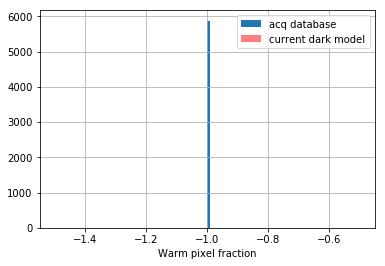

In [26]:
n, bins, patches = plt.hist(data_all['warm_pix'], bins=100, label='acq database')
plt.grid()
plt.xlabel('Warm pixel fraction')

plt.hist(warm_fracs, bins=bins, facecolor='r', alpha=0.5, label='current dark model')
plt.legend();

In [27]:
# Substitute current dark model values instead of acq database
data_all['warm_pix'] = warm_fracs

In [28]:
data_all = data_all.group_by('quarter')
data_mean = data_all.groups.aggregate(np.mean)

In [29]:
np.count_nonzero(data_all['obc_id'])

3917

In [30]:
def p_fail(pars, m10, wp, box_delta=0.0):
    """
    Acquisition probability model

    :param pars: 7 parameters (3 x offset, 3 x scale, p_fail for bright stars)
    :param m10: mag - 10
    :param wp: warm pixel fraction
    :param box: search box half width (arcsec)
    """
    scl0, scl1, scl2 = pars[0:3]
    off0, off1, off2 = pars[3:6]
    p_bright_fail = pars[6]


    scale = scl0 + scl1 * m10 + scl2 * m10**2
    offset = off0 + off1 * m10 + off2 * m10**2

    p_fail = offset + scale * wp + box_delta
    p_fail = stats.norm.cdf(p_fail)  # probit transform
    p_fail[m10 < -1.5] = p_bright_fail  # For stars brighter than 8.5 mag use a constant

    return p_fail

def p_acq_fail(data=None):
    """
    Sherpa fit function wrapper to ensure proper use of data in fitting.
    """
    if data is None:
        data = data_all
        
    m10 = data['mag10']
    wp = data['warm_pix']
    box_delta = data['box_delta']

    def sherpa_func(pars, x):
        return p_fail(pars, m10, wp, box_delta)

    return sherpa_func

In [31]:
np.count_nonzero(data_all['ion_rad'])

0

In [32]:
def fit_sota_model(data_mask=None, ms_disabled=False):
    from sherpa import ui

    obc_id = data_all['obc_id']
    if ms_disabled:
        obc_id |= (data_all['img_func'] == 'star') & ~data_all['ion_rad'] & ~data_all['sat_pix']    
    data_all['fail'] = np.where(obc_id, 0.0, 1.0)

    data = data_all if data_mask is None else data_all[data_mask]

    data_id = 1
    ui.set_method('simplex')
    ui.set_stat('cash')
    ui.load_user_model(p_acq_fail(data), 'model')
    ui.add_user_pars('model', ['scl0', 'scl1', 'scl2', 'off0', 'off1', 'off2', 'p_bright_fail'])
    ui.set_model(data_id, 'model')
    ui.load_arrays(data_id, np.array(data['year']), np.array(data['fail'], dtype=np.float))

    # Initial fit values from fit of all data
    start_vals = iter(SOTA2015_FIT_ALL)  # Offset
    fmod = ui.get_model_component('model')
    for name in ('scl', 'off'):
        for num in (0, 1, 2):
            comp_name = name + str(num)
            setattr(fmod, comp_name, next(start_vals))
            comp = getattr(fmod, comp_name)
            comp.min = -100000
            comp.max = 100000
            # ui.freeze(comp)
    
    fmod.p_bright_fail = 0.025
    fmod.p_bright_fail.min = 0.0
    fmod.p_bright_fail.max = 1.0
    # ui.freeze(fmod.p_bright_fail)
    
    ui.fit(data_id)
    # conf = ui.get_confidence_results()
    return ui.get_fit_results()

## Plotting and validation

In [33]:
def plot_fit_grouped(pars, group_col, group_bin, mask=None, log=False, colors='br', label=None):
    data = data_all if mask is None else data_all[mask]
    data['model'] = p_acq_fail(data)(pars, None)

    group = np.trunc(data[group_col] / group_bin)
    data = data.group_by(group)
    data_mean = data.groups.aggregate(np.mean)
    len_groups = np.diff(data.groups.indices)
    fail_sigmas = np.sqrt(data_mean['fail'] * len_groups) / len_groups
    
    plt.errorbar(data_mean[group_col], data_mean['fail'], yerr=fail_sigmas, fmt='.' + colors[0], label=label)
    plt.plot(data_mean[group_col], data_mean['model'], '-' + colors[1])
    if log:
        ax = plt.gca()
        ax.set_yscale('log')

In [34]:
def mag_filter(mag0, mag1):
    ok = (data_all['mag'] > mag0) & (data_all['mag'] < mag1)
    return ok

In [35]:
def wp_filter(wp0, wp1):
    ok = (data_all['warm_pix'] > wp0) & (data_all['warm_pix'] < wp1)
    return ok

In [36]:
def print_fit_results(fit, label):
    label = label + ' = ['
    print(label, end='')
    space = ''
    for parname, parval in zip(fit.parnames, fit.parvals):
        parname = re.sub(r'model\.', '', parname)
        print(f'{space}{parval:.5f},  # {parname}')
        space = ' ' * len(label)
    print(space + ']')

In [37]:
def plot_fit_all(fit, mask=None):
    print(fit)
    parvals = [par.val for par in model.pars]
    print(parvals)
    if mask is None:
        mask = np.ones(len(data_all), dtype=bool)
    
    try:
        plt.figure()
        plot_fit_grouped(parvals, 'mag', 0.25, wp_filter(0.2, 0.30) & mask, log=False, colors='cm', label='0.10 < WP < 0.2')
        plot_fit_grouped(parvals, 'mag', 0.25, wp_filter(0.3, 0.33) & mask, log=False, colors='br', label='0 < WP < 0.10')
        plot_fit_grouped(parvals, 'mag', 0.25, wp_filter(0.33, 0.38) & mask, log=False, colors='cm', label='0.10 < WP < 0.2')
        plot_fit_grouped(parvals, 'mag', 0.25, wp_filter(0.38, 0.40) & mask, log=False, colors='br', label='0 < WP < 0.10')
        plot_fit_grouped(parvals, 'mag', 0.25, wp_filter(0.40, 0.45) & mask, log=False, colors='br', label='0 < WP < 0.10')
        plt.legend(loc='upper left');
        plt.ylim(0.001, 1.0);
        plt.xlim(9, 11)
        plt.grid()
    except:
        pass
    
    plt.figure()
    plot_fit_grouped(parvals, 'warm_pix', 0.02, mag_filter(10, 10.6) & mask, log=True, colors='cm', label='10 < mag < 10.6')
    plot_fit_grouped(parvals, 'warm_pix', 0.02, mag_filter(9, 10) & mask, log=True, colors='br', label='9 < mag < 10')
    plt.legend(loc='best')
    plt.grid()
    
    plt.figure()
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(10, 10.6) & mask, colors='cm', label='10 < mag < 10.6')
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(9.0, 10) & mask, colors='br', label='9.5 < mag < 10')
    # plot_fit_grouped(parvals, 'year', 0.25, mag_filter(9.0, 9.5) & mask,  colors='gk', label='9.0 < mag < 9.5')
    plt.legend(loc='best')
    plt.grid()
    
    plt.figure()
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(10, 10.6) & mask, colors='cm', label='10 < mag < 10.6', log=True)
    plot_fit_grouped(parvals, 'year', 0.25, mag_filter(9.0, 10) & mask, colors='br', label='9.5 < mag < 10', log=True)
    # plot_fit_grouped(parvals, 'year', 0.25, mag_filter(9.0, 9.5) & mask,  colors='gk', label='9.0 < mag < 9.5', log=True)
    plt.legend(loc='best')
    plt.grid();

### Color != 1.5 fit

In [38]:
print('Hang tight, this could take a few minutes')
# fit = fit_sota_model(data_all['color'] == 1.5, ms_disabled=True)
mask = data_all['color'] != 1.5
fit_n1p5 = fit_sota_model(mask, ms_disabled=True)

Hang tight, this could take a few minutes
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 6934.4
Final fit statistic   = 6592.08 at function evaluation 1369
Data points           = 5880
Degrees of freedom    = 5873
Change in statistic   = 342.319
   model.scl0     7.78471     
   model.scl1     -3.70337    
   model.scl2     -2.84246    
   model.off0     -3.19593    
   model.off1     2.86478     
   model.off2     1.28957     
   model.p_bright_fail   0.0353741   


In [39]:
print_fit_results(fit_n1p5, 'SOTA2017_FIT_NO_1P5')

SOTA2017_FIT_NO_1P5 = [7.78471,  # scl0
                       -3.70337,  # scl1
                       -2.84246,  # scl2
                       -3.19593,  # off0
                       2.86478,  # off1
                       1.28957,  # off2
                       0.03537,  # p_bright_fail
                       ]


datasets       = (1,)
itermethodname = none
methodname     = neldermead
statname       = cash
succeeded      = True
parnames       = ('model.scl0', 'model.scl1', 'model.scl2', 'model.off0', 'model.off1', 'model.off2', 'model.p_bright_fail')
parvals        = (7.7847109353662622, -3.7033653027479323, -2.8424641926188121, -3.1959274611623671, 2.8647841902126681, 1.2895678188265816, 0.035374149530065943)
statval        = 6592.082508822351
istatval       = 6934.401298916401
dstatval       = 342.318790094
numpoints      = 5880
dof            = 5873
qval           = None
rstat          = None
message        = Optimization terminated successfully
nfev           = 1369
[7.7847109353662622, -3.7033653027479323, -2.8424641926188121, -3.1959274611623671, 2.8647841902126681, 1.2895678188265816, 0.035374149530065943]


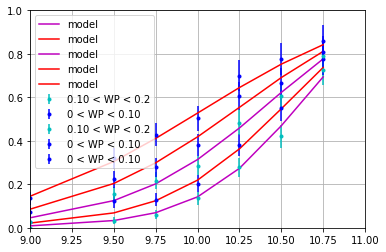

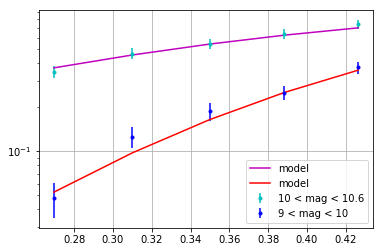

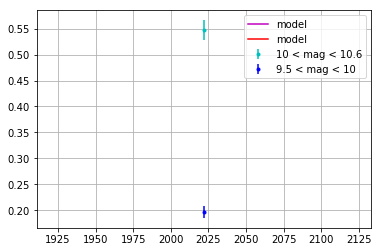

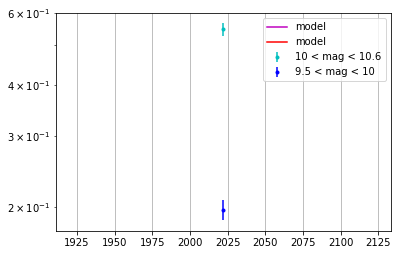

In [40]:
plot_fit_all(fit_n1p5, mask=mask)

### Intermediate validation : plot acq success probabilities in T_ccd, mag bins

In [41]:
datcg = data_all.group_by(['mag', 'ccd_temp', 'halfwidth'])
datcgm = datcg.groups.aggregate(np.mean)

In [42]:
datcgm[:4]

obsid,search_success,halfwidth,mag,ccd_temp,obc_id,tstart,warm_pix,ion_rad,sat_pix,color,known_bad,box_delta,year,quarter,color_1p5,mag10,fail
float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,1.0,60,8.0,-13,1.0,757425669.184,0.269528922848,0.0,0.0,1.0,0.0,-0.555,2022.00127551,91.0,0.0,-2.0,0.0
0.0,1.0,120,8.0,-13,1.0,757425669.184,0.269528922848,0.0,0.0,1.0,0.0,0.0,2022.00127551,91.0,0.0,-2.0,0.0
0.0,0.979591836735,180,8.0,-13,0.979591836735,757425669.184,0.269528922848,0.0,0.0,1.0,0.0,0.405,2022.00127551,91.0,0.0,-2.0,0.0204081632653
0.0,1.0,60,8.0,-11,1.0,757425669.184,0.310007738987,0.0,0.0,1.0,0.0,-0.555,2022.00127551,91.0,0.0,-2.0,0.0


In [49]:
#    data = data_all if mask is None else data_all[mask]
#    data['model'] = p_acq_fail(data)(pars, None)
# def p_fail(pars, m10, wp, box_delta=0.0):

def plot_probs(dat_mean, date=None, halfwidth=None):
    mags = np.linspace(8, 11, 50)
    t_ccds = sorted(set(dat_mean['ccd_temp']))

    plt.figure(figsize=(12, 5))
    for ii, t_ccd0 in enumerate(t_ccds):
        plt.subplot(2, 3, ii + 1)
        for t_ccd in t_ccds:
            ok = (dat_mean['ccd_temp'] == t_ccd) & (dat_mean['halfwidth'] == halfwidth)
            t = dat_mean[ok]
            alpha = 1.0 if t_ccd0 == t_ccd else 0.25
            lw = 2.5 if t_ccd0 == t_ccd else 1.0
            plt.plot(t['mag'], t['search_success'], 'o-b', alpha=alpha, lw=lw)
            date_mean = date or np.mean(t['guide_tstart'])
            t_ccd_mean = np.mean(t['ccd_temp'])  # ACTUAL mean ccd_temp for sample
            p_model = star_probs.acq_success_prob(mag=mags, t_ccd=t_ccd_mean, date=date_mean,
                                                halfwidth=halfwidth)
            # print(t['warm_pix'][0], t['box_delta'][0])
            # p_model = 1 - p_fail(SOTA2022_FIT_NO_1P5, m10=mags-10.0, wp=t['warm_pix'][0],
            #                     box_delta=t['box_delta'][0])
            #print(p_model)
            plt.plot(mags, p_model, '-r', lw=lw, alpha=alpha)
            if t_ccd0 == t_ccd:
                plt.title('T_ccd={:.1f}  Mean date={}'
                          .format(t_ccd_mean, DateTime(date_mean).date[:8]))
        plt.grid()
        plt.margins(0.05)
    plt.tight_layout()

In [44]:
np.count_nonzero(data_all['warm_pix'] < 0)

0

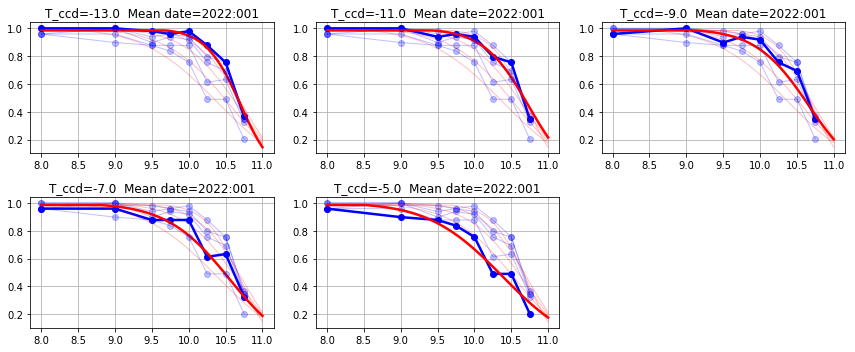

In [51]:
plot_probs(datcgm, date='2022:001', halfwidth=60)

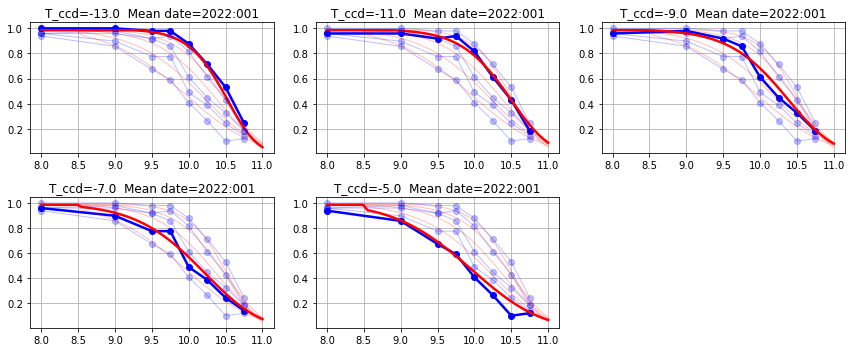

In [52]:
plot_probs(datcgm, date='2022:001', halfwidth=120)

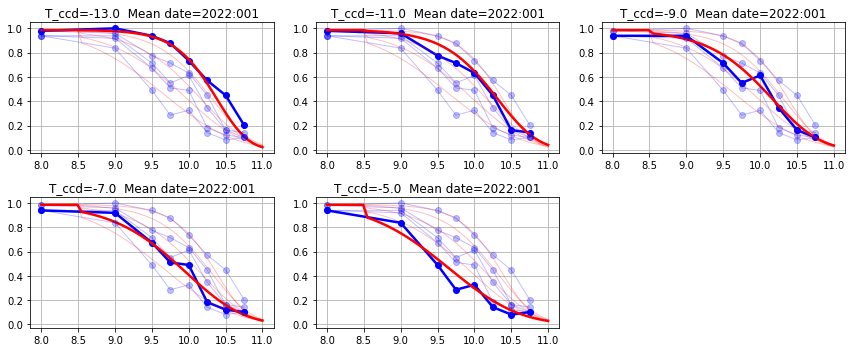

In [53]:
plot_probs(datcgm, date='2022:001', halfwidth=180)

In [ ]:
print('Hang tight, this could take a few minutes')
mask = data_all['color'] == 1.5
fit_1p5 = fit_sota_model(mask, ms_disabled=True)

In [ ]:
print_fit_results(fit_1p5, 'SOTA2017_FIT_ONLY_1P5')

In [ ]:
plot_fit_all(fit_1p5, mask=mask)

## Compare 2017 to 2015 coefficients

### Failure prob vs. mag for Wp=(0.1, 0.2, 0.3)


In [ ]:
mag = np.linspace(9, 11, 30)
for wp in (0.1, 0.2, 0.3):
    plt.plot(mag, p_fail(SOTA2015_FIT_NO_1P5, mag-10, wp), 'r', 
             label='2015 model' if wp == 0.1 else None)
    plt.plot(mag, p_fail(SOTA2017_FIT_NO_1P5, mag-10, wp), 'b', 
             label='2017 model' if wp == 0.1 else None)

plt.grid()
plt.xlabel('Mag')
plt.ylim(0, 1)
plt.title('Failure prob vs. mag for Wp=(0.1, 0.2, 0.3)')
plt.legend(loc='upper left')
plt.ylabel('Prob');

### Failure prob vs. Wp for mag=(10.0, 10.25, 10.5)

In [ ]:
for mag in (10.0, 10.25, 10.5):
    wp = np.linspace(0, 0.4, 30)
    plt.plot(wp, p_fail(SOTA2015_FIT_NO_1P5, mag-10, wp), 'r',
                        label='2015 model' if mag == 10.0 else None)
    plt.plot(wp, p_fail(SOTA2017_FIT_NO_1P5, mag-10, wp), 'b',
                        label='2017 model' if mag == 10.0 else None)

plt.grid()
plt.xlabel('Warm pix frac')
plt.ylim(0, 1)
plt.title('Failure prob vs. Wp for mag=(10.0, 10.25, 10.5)')
plt.ylabel('Fail prob');